In [1]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
      
sns.set()

import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show

from collections import Counter

Loading BokehJS ...

In [2]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

In [3]:
datadir = '../Data/NCI109/'

## read data from NCI folder
fn_edges = datadir+'DS_A.txt'
fn_graph_id = datadir+'DS_graph_indicator.txt'
fn_graph_label = datadir+'DS_graph_labels.txt'
fn_node_label = datadir+'DS_node_labels.txt'


## NCI Datasets

We build one large graph from 4000+ smaller ones. 
For each vertex, we have the following attributes:
* name: unique for each vertex (1-based str)
* graph: the small graph this node belongs to (1-based int)
* label: the vertex label (1-based int)

Note that some vertices have label and are assigned to a small graph, but are not part of any edge.
We add those as isolated vertices nevertheless.


In [4]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip()) for x in f.readlines()]
    
## some vertices do not appear in any edges
## we add those as isolated nodes for easier processing.
vertices = set(G.vs['name'])
print('number of vertices before:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))
v = set(np.arange(1,len(sg_mem)+1))
diff = v.difference(vertices)
G.add_vertices(list(diff))
print('number of vertices afteur:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))

## mapping nodes in order of name
node_idx = list(np.argsort(G.vs['name']))

## assign subgraph
for i in range(len(sg_mem)):
    G.vs[node_idx[i]]['graph'] = sg_mem[i]

## verify with graph label list -- should output 'True'
l = [G.vs[i]['graph'] for i in node_idx]
if l != sg_mem:
    print('something is wrong')

## read and store node labels
with open(fn_node_label) as f:
    l = [int(x.strip()) for x in f.readlines()]
for i in range(len(l)):
    G.vs[node_idx[i]]['label'] = l[i]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]

G.vs['name'] = [str(i) for i in G.vs['name']]
    

number of vertices before: 122020 min index: 1 max index: 122494
number of vertices afteur: 122494 min index: 1 max index: 122494


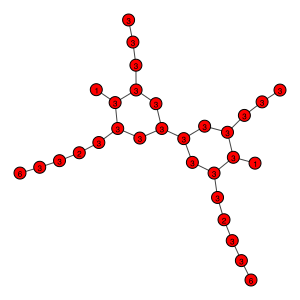

In [5]:
## subgraphs are easy to get
sg_no = 100
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_no)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=12, vertex_label_size=8)

## Method 2 - walks


In [6]:
walk_len = 100
walk_nbr = 100

In [7]:
L1 = []
for i in range(max(G.vs['graph'])):
    L2 = []
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i+1)[0].tolist())
    Deg = sg.degree()
    Lab = sg.vs['label']
    n = sg.vcount()
    ctr = 0
    while ctr<walk_nbr:
        v = [str(Deg[k])+'_'+str(Lab[k]) for k in sg.random_walk(start=np.random.choice(n), steps=walk_len-1)]
        if len(v)==walk_len:
            L2.append(np.array(v))
            ctr += 1
    L2 = np.array(L2)
    L1.append(L2)
L = np.array(L1, dtype=object)

In [8]:
walks = np.vstack(L)

In [9]:
walks.shape

(412700, 100)

In [10]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=2,
    window_radii=(1, 20),
    window_functions=("fixed", "variable"),
    kernel_functions=("geometric", "geometric"),
    kernel_args=({}, {"offset":1}),
    #mask_string="[##MASK##]",
    #nullify_mask=True,
    n_iter=2,
    normalize_windows=True,
    n_threads=4,
).fit(walks)
word_vectors = word_vectorizer.transform(walks)


CPU times: user 32min 3s, sys: 5.1 s, total: 32min 8s
Wall time: 8min 43s


In [11]:
%%time
ngrammer = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
)
doc_matrix = ngrammer.fit_transform(walks)

CPU times: user 1min 54s, sys: 2.55 s, total: 1min 56s
Wall time: 1min 56s


In [12]:
doc_matrix

<412700x42 sparse matrix of type '<class 'numpy.float32'>'
	with 2144565 stored elements in Compressed Sparse Row format>

In [13]:
word_vectorizer.token_label_dictionary_

{'1_1': 0,
 '1_17': 1,
 '1_2': 2,
 '1_21': 3,
 '1_3': 4,
 '1_36': 5,
 '1_4': 6,
 '1_5': 7,
 '1_6': 8,
 '1_8': 9,
 '2_1': 10,
 '2_10': 11,
 '2_11': 12,
 '2_17': 13,
 '2_2': 14,
 '2_3': 15,
 '2_32': 16,
 '2_34': 17,
 '2_36': 18,
 '2_5': 19,
 '3_10': 20,
 '3_17': 21,
 '3_2': 22,
 '3_20': 23,
 '3_21': 24,
 '3_28': 25,
 '3_29': 26,
 '3_3': 27,
 '3_5': 28,
 '3_7': 29,
 '4_10': 30,
 '4_11': 31,
 '4_2': 32,
 '4_20': 33,
 '4_22': 34,
 '4_28': 35,
 '4_3': 36,
 '4_36': 37,
 '4_5': 38,
 '4_6': 39,
 '4_7': 40,
 '5_7': 41}

In [14]:
n_g = max(G.vs['graph'])
n_g

4127

In [15]:
%%time
Inc = np.array(np.arange(0,n_g*walk_nbr)).reshape((n_g,walk_nbr))
inc_matrix = vectorizers.NgramVectorizer(
).fit_transform(Inc)


CPU times: user 1.42 s, sys: 43.3 ms, total: 1.46 s
Wall time: 1.46 s


In [16]:
awe_matrix = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(inc_matrix, vectors=doc_matrix)

In [17]:
awe_matrix.shape

(4127, 42)

In [18]:
g_mapper = umap.UMAP(random_state=42).fit(awe_matrix)


In [19]:
p = umap.plot.interactive(
    g_mapper, 
    labels=graph_labels,
    point_size=3, 
    width=800, 
    height=600, 
    theme='fire')
show(p)

### Method 1 - Vertex Features

Given one of the small graphs, compute some features


In [20]:
def get_sg_features(sg):
    F = []
    n = sg.vcount()
    sg.vs['deg'] = sg.degree()
    F.append(sg.vs['deg'])
    F.append(sg.vs['label'])
    for v in sg.vs:
        w = [sg.vs[i]['label'] for i in sg.neighborhood(v)]
        v['ml'] = np.mean(w)
        v['nl'] = len(set(w))    
        w = [sg.vs[i]['deg'] for i in sg.neighborhood(v)]
        v['md'] = np.mean(w)
        v['nd'] = len(set(w))    
        dg = np.zeros(5)
        for d in w:
            dg[min(d,5)-1]+=1
        s = sum(dg)
        v['dg'] = [i/s for i in dg]
    F.append(sg.vs['ml'])
    F.append(sg.vs['nl'])
    F.append(sg.vs['md'])
    F.append(sg.vs['nd'])
    #for i in range(5):
    #    F.append(sg.vs['dg'][i])
    for i in range(7):
        F.append([i/n for i in sg.neighborhood_size(order=i+1)])
    F.append(np.array(sg.betweenness())/sg.vcount()**2)
    F.append(sg.pagerank())
    F.append(sg.transitivity_local_undirected(mode='zero'))
    F = np.array(F).transpose()
    return F

#### What we need:

* node_features: array (number of graphs) or arrays of size (number of vertices x number of features)
* graph_vertices: array (number of graphs) of lists of vertex names (unique, strings)


In [21]:
%%time
node_features = []
graphs_vertices = []
for i in list(set(G.vs['graph'])):
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist())
    node_features.append(get_sg_features(sg))
    graphs_vertices.append(np.array(sg.vs['name']))
node_features = np.array(node_features, dtype=object)
graphs_vertices = np.array(graphs_vertices, dtype=object)

CPU times: user 27.5 s, sys: 96.6 ms, total: 27.6 s
Wall time: 27.6 s


In [22]:
node_features[0].shape

(19, 16)

## Details TBD


In [23]:
vertex_vectors_0 = np.vstack(node_features)
vertex_vectors_0.shape

(122494, 16)

In [24]:
## list all vertex names, build ref dict
vertex_names = list(np.hstack(graphs_vertices))
vertex_names_dictionary = dict()
for i, v in enumerate(vertex_names):
    vertex_names_dictionary[v] = i    
n_vertices = len(vertex_names_dictionary)

In [25]:
graphs_vertices[0]

array(['18', '1', '5', '2', '3', '7', '4', '9', '12', '6', '8', '10',
       '11', '14', '15', '16', '13', '17', '19'], dtype='<U2')

In [26]:
%%time
## build graphs x vertices incidence given above ref dict
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=vertex_names_dictionary
).fit(graphs_vertices)

incidence_matrix = incidence_vectorizer.transform(graphs_vertices)

CPU times: user 1.11 s, sys: 18.7 ms, total: 1.13 s
Wall time: 1.13 s


In [27]:
incidence_matrix

<4127x122494 sparse matrix of type '<class 'numpy.float32'>'
	with 122494 stored elements in Compressed Sparse Row format>

In [28]:
vertex_vectors_0.shape

(122494, 16)

In [29]:
%%time
n_components = vertex_vectors_0.shape[0]
graph_awe_matrix_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_0)
graph_awe_matrix_0.shape

CPU times: user 2min 21s, sys: 20.1 s, total: 2min 41s
Wall time: 32.1 s


(4127, 16)

In [30]:
g_mapper = umap.UMAP(random_state=42).fit(graph_awe_matrix_0)


In [31]:
p = umap.plot.interactive(
    g_mapper, 
    labels=graph_labels,
    point_size=3, 
    width=800, 
    height=600, 
    theme='fire')
show(p)

In [32]:
%%time
vertex_vectors_norm_0 = normalize(vertex_vectors_0, axis=1, norm='l1')
n_components = vertex_vectors_norm_0.shape[0]
graph_awe_matrix_norm_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_norm_0)
graph_awe_matrix_norm_0.shape

CPU times: user 2min 21s, sys: 15.7 s, total: 2min 36s
Wall time: 28.9 s


(4127, 16)

In [33]:
g_mapper = umap.UMAP(random_state=42).fit(graph_awe_matrix_norm_0)


In [34]:
p = umap.plot.interactive(
    g_mapper, 
    labels=graph_labels,
    point_size=3, 
    width=800, 
    height=600, 
    theme='fire')
show(p)

In [35]:
def cross_validate(model, data, labels, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, labels, cv=splitter)
    return result

def cross_validation_dataframe(model, data, labels, feature_sets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, labels, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores,
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

In [36]:
models_norm = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    # sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets_norm = {
    "Wasserstein original": graph_awe_matrix_0,
    "Wasserstein normalized":  graph_awe_matrix_norm_0,
    "Walks": awe_matrix
}

In [37]:
%%time
results_norm = []
for model in models_norm:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets_norm,
        graph_labels,
        feature_sets = feature_sets_norm
    )
    results_norm.append(res)

df_norm = pd.concat( results_norm )

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')
RandomForestClassifier()
CPU times: user 1min 12s, sys: 5.73 s, total: 1min 17s
Wall time: 1min 9s


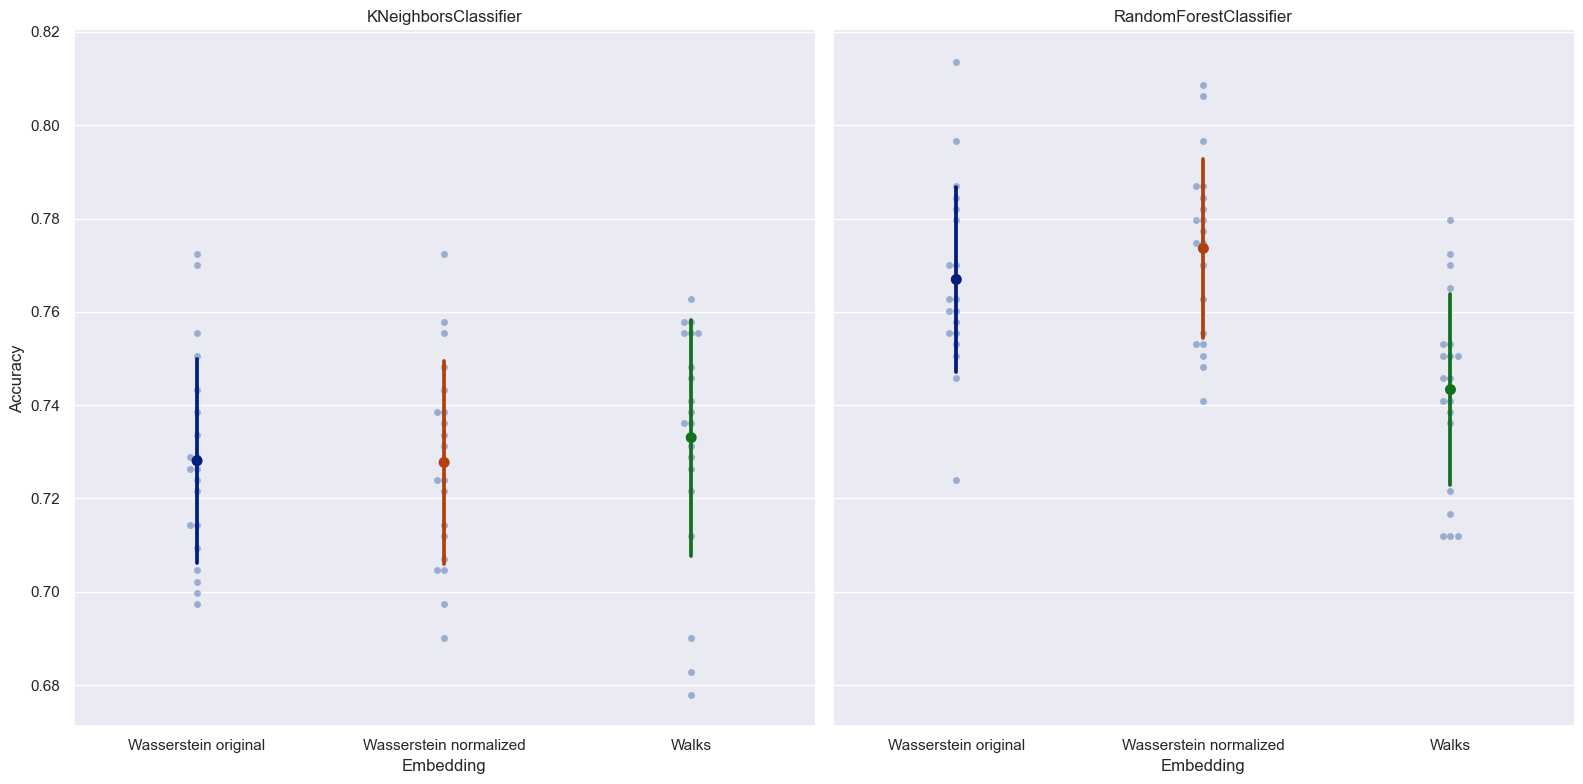

In [38]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df_norm, 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df_norm, 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Wasserstein original",
        "Wasserstein normalized",
        "Walks"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
        "Wasserstein original",
        "Wasserstein normalized",
        "Walks"
    ]);


## Recursive part

as per VP's